In [1]:
import pints
import numpy as np
import math
from scipy.constants import N_A
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, brentq
from numba import njit
import pandas as pd

In [2]:
#Constants

Target_cell_number = 1e4
E_T_ratio = 5
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2


t_end = 60*60*5
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

kons = [2.5e5, 2e5, 1.4e5, 1.1e5]
qon = 6.5e3
koffs = [1.6e-4, 1.4e-3, 3.3e-3, 1.6e-2]
qoff = 4.7e-3
rtot = 5.3e4
ftot=2.2e5
D_t = 6.8e-15
D_f = 7.4e-14

In [3]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot

    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

@njit
def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, rtot_fc_synapse, Atot):


    A0 = Atot - (z[0] + z[1] + z[3] + z[4] + z[2])
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 =  - k2*z[0]*(rt) + 2*1*k1off*z[1] - k4*z[0]*(rf) + 1*k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*1*k1off*z[1] - k5*z[1]*(rf) + 1*k2off*z[4]
    dA01 =   - 2*k6*1*z[2]*(rt) + k1off*1*z[3]
    dA11 = k4*z[0]*(rf) - 1*k2off*z[3] + 2*k6*1*z[2]*(rt) -k1off*1*z[3] - k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - 1*k2off*z[4] + k7*z[3]*(rt) - 2*1*k1off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [4]:
print(2*(D_t +D_f)/(synapse_area))  

0.0016159999999999996


In [5]:
def calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, chi, chi2):
    
    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1

    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-2], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)
    
        
    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
        
    A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
    A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
    A1_E_pre_synapse = np.float64(A1_E_stst*NK_cell_IS_proportion)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    Atot =A1_pre_synapse + A2_pre_synapse + A1_E_pre_synapse
    z_0 = [A1_pre_synapse, A2_pre_synapse, A1_E_pre_synapse, 0, 0]
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(synapse_area)
    #k4 = 2*(D_t +D_f)/(synapse_area)   
    #k5 = (2*(D_t +D_f)/(synapse_area))/chi
    k4 = chi2
    k5 = chi
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = (2*D_t/synapse_area)
    z = solve_ivp(S_two_cells, tspan, z_0, method='BDF',  rtol = 1e-4, atol=1e-3, t_eval=t, args=[k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, ftot_synapse, Atot])
    if z.success == False:
        print(z.message)
    A11 = z.y[3]
    A21 = z.y[4]
  

    crosslinks = (A11[-1] + A21[-1])
    
    
    return crosslinks

In [6]:
@njit
def fc_func(Emax, Efc50, fc):

    return (Emax*(fc))/(Efc50 + (fc))

def simulate_model_individual(A0s, chi, chi2, Efc50, ftot, kon, koff, Emax):

    solution = np.zeros_like(A0s)

    for i, Ainit in enumerate(A0s):
        solution[i] = calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, chi, chi2)
        
    
    solution = fc_func(Emax, Efc50, solution)
    return solution

def simulate_model(A0s, parameters):
    chi = parameters[0]
    chi = 10**chi
    chi2 = parameters[1]
    chi2 = 10**chi2
    Efc50 = parameters[2]
    Efc50 = 10**Efc50
    #Efc502 = parameters[3]
    #Efc502 = 10**Efc502
    #Efc503 = parameters[4]
    #Efc503 = 10**Efc503
    #Efc504 = parameters[5]
    #Efc504 = 10**Efc504
    Emax = parameters[3]
    Emax= 10**Emax
    #Emax2 = parameters[7]
    #Emax3 = parameters[8]
    #Emax2 = 10**Emax2
    #Emax3 = 10**Emax3
    #Emax4 = parameters[9]
    #Emax4 = 10**Emax4
    solution1 = np.zeros((len(A0s), len(kons)))
    c = parameters[4]
    c = 10**c
    #Efc50s = [Efc501, Efc502, Efc503, Efc504]
    #Emaxs = [Emax1, Emax2, Emax3, Emax4]
    for i, kon in enumerate(kons):
            solution1[:, i] = simulate_model_individual(A0s, chi, chi2, Efc50, ftot, kon, koffs[i], Emax)
            solution1[:, i] = c + solution1[:, i]
        
    return solution1
    
class model(pints.ForwardModel):

    def n_outputs(self):
         return 4
    
    def n_parameters(self):
        return 5
    
    def simulate(self, parameters, A0s):
        return simulate_model(A0s, parameters)

In [7]:
#extract data

df = pd.read_csv('/Users/lukeheirene/ADCC-Project/__pycache__/Synapse Model Parameter Fitting/Mazor_data/SK0V3_WT_5:1.csv')
df1 = pd.read_csv('/Users/lukeheirene/ADCC-Project/__pycache__/Synapse Model Parameter Fitting/Mazor_data/SK0V3_VKF94A_5:1.csv')
df3 = pd.read_csv('/Users/lukeheirene/ADCC-Project/__pycache__/Synapse Model Parameter Fitting/Mazor_data/SK043_VSF93A+VHP97A_5:1.csv')
df2 = pd.read_csv('/Users/lukeheirene/ADCC-Project/__pycache__/Synapse Model Parameter Fitting/Mazor_data/SK043_VKF94A+VHP97A_5:1 copy.csv')
A0s1 = df['concentration'].values
A0s2 = df1['concentration'].values
A0s3 = df2['concentration'].values
A0s4 = df3['concentration'].values
print(len(A0s1))
A0s1 = A0s1*1e-9
values1 = df[' cytotoxicity RLU']
values2 = df1[' cytotoxicity RLU']
values3 = df2[' cytotoxicity RLU']
values4 = df3[' cytotoxicity RLU']
values = np.zeros((len(A0s1), 4))
for i in range(len(A0s1)):
    values[i, 0] = values1[i]
    values[i, 1] = values2[i]
    values[i, 2] = values3[i]
    values[i, 3] = values4[i]
#values = values/np.max(values)
print(values.shape)
print(values)

9
(9, 4)
[[ 5.23489933  3.22147651  1.0738255   1.20805369]
 [ 5.90604027  5.90604027  0.26845638  0.67114094]
 [10.46979866 10.87248322  5.36912752  3.75838926]
 [20.40268456 18.38926174  4.69798658  6.84563758]
 [19.59731544 21.47651007 13.55704698 11.00671141]
 [24.96644295 22.55033557 19.86577181 16.91275168]
 [26.57718121 24.96644295 27.91946309 19.86577181]
 [22.55033557 26.7114094  32.08053691 25.90604027]
 [26.17449664 31.67785235 53.02013423 35.03355705]]


In [12]:
print(values.shape)

(9, 4)


In [9]:
mod = model()
problem = pints.MultiOutputProblem(mod, A0s1, values)
log_likelihood = pints.GaussianLogLikelihood(problem)
print(log_likelihood.n_parameters())
parameters = [-9, -6, 0.5, 0.2, 1.5, 10, 10, 10, 10]
#print(parameters)
log_prior = pints.UniformLogPrior(
    [-15, -12, -2, -1, -1, 0.01, 0.01, 0.01, 0.01],
    [-1, -1, 3, 1.5, 4, 50, 50, 50, 50]
)

log_posterior = pints.LogPosterior(log_likelihood, log_prior)

9


In [10]:
xs = [
    np.array(parameters) * 0.85,
    np.array(parameters) * 0.95,
    np.array(parameters) * 1.05,
    np.array(parameters) * 1.15 
]

In [11]:
mcmc = pints.MCMCController(log_posterior, 4, xs)
mcmc.set_max_iterations(10000)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:01.5


KeyboardInterrupt: 

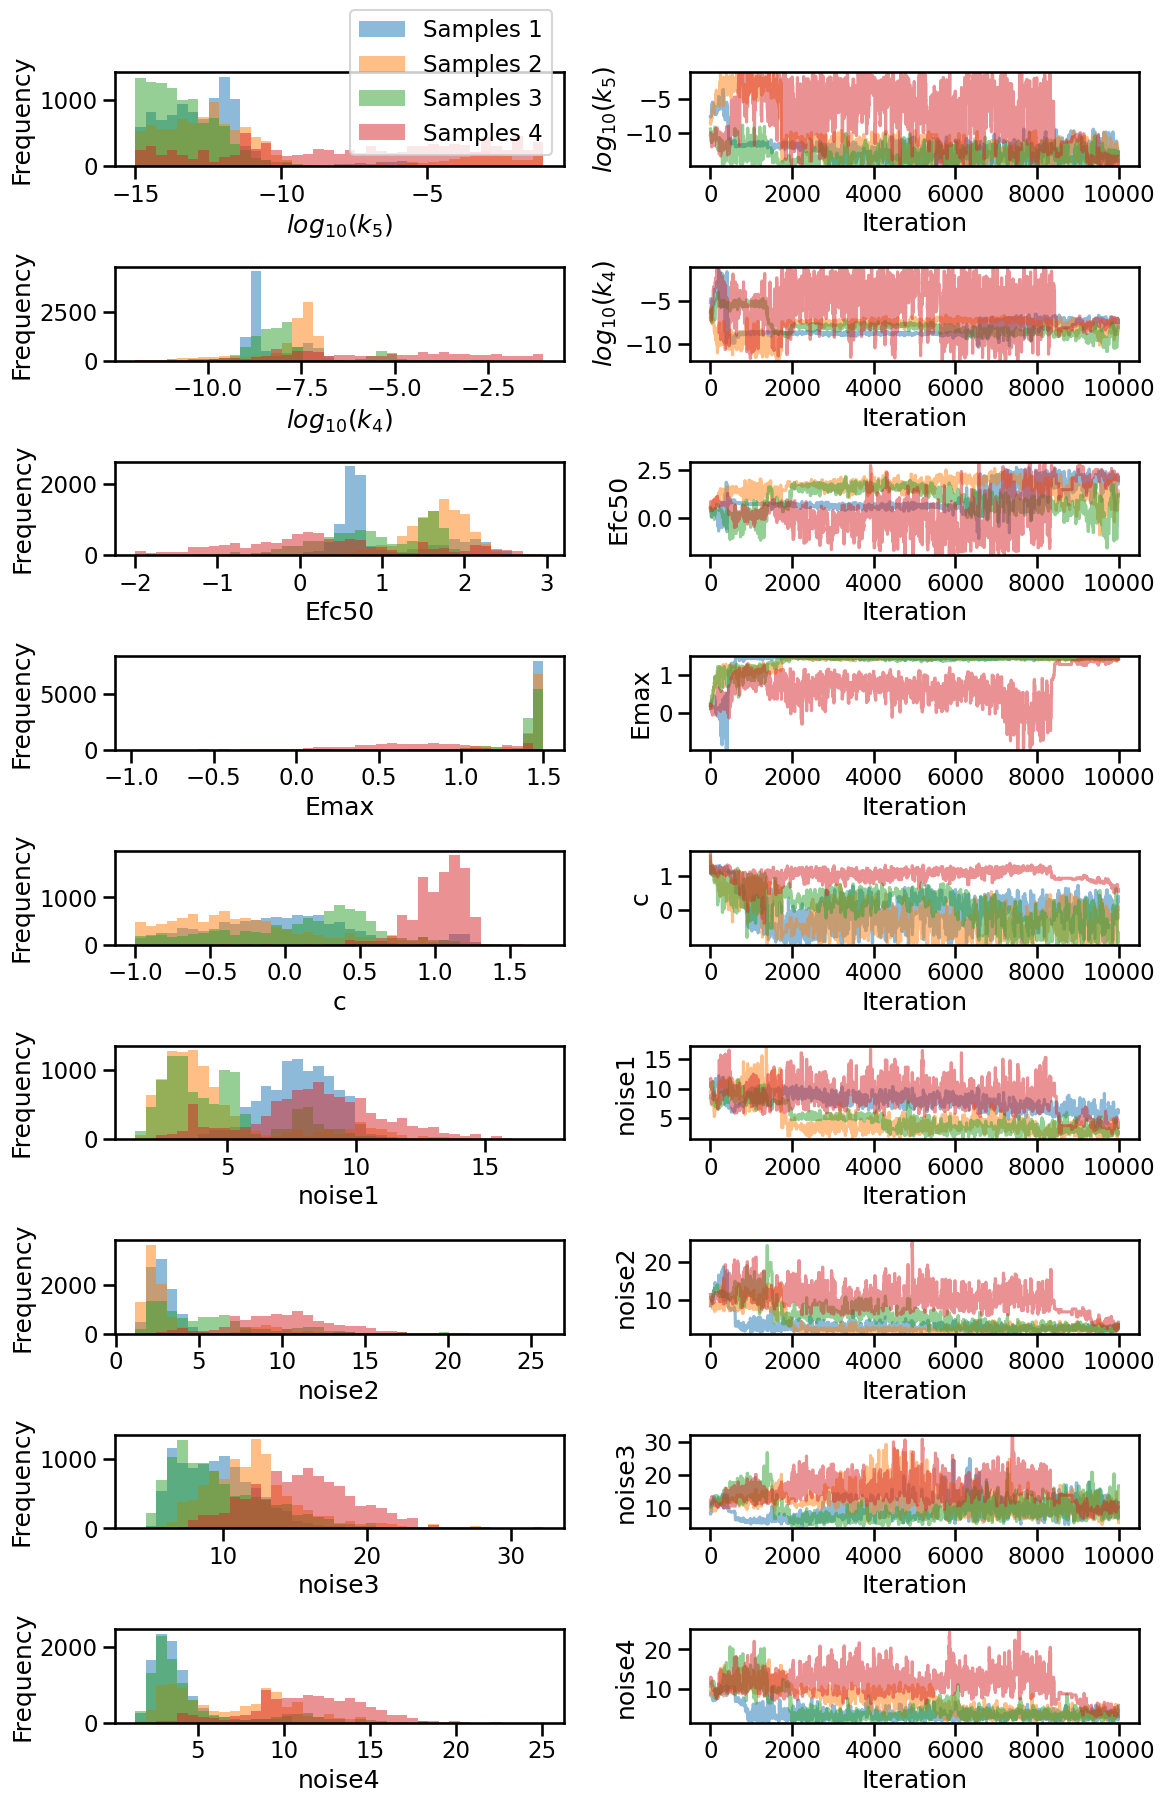

In [ ]:
import pints.plot
pints.plot.trace(chains, parameter_names=[r'$log_{10}(k_5)$', r'$log_{10}(k_4)$', r'Efc50', 'Emax', 'c', 'noise1', 'noise2', 'noise3', 'noise4'])
plt.show()

In [ ]:
chain = chains[0]
chain = chain[8000:]
chains1 = chains[:, 8000 :]

In [ ]:
results = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=[r'log10(k5)', r'log10(k4)', r'Efc50', 'Emax', 'c', 'noise1', 'noise2', 'noise3', 'noise4'])
print(results)


param      mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
---------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
log10(k5)  -12.79  1.91    -14.88  -14.16  -13.16  -11.92  -6.77    1.22    193.43  0.02
log10(k4)  -7.85   1.19    -9.76   -8.49   -7.88   -7.37   -3.70    1.32    112.51  0.01
Efc50      1.33    0.83    -0.57   0.75    1.48    1.99    2.55     1.62    113.35  0.01
Emax       1.37    0.30    0.15    1.42    1.44    1.46    1.49     1.38    247.59  0.03
c          0.03    0.63    -0.93   -0.49   -0.06   0.59    1.19     2.20    191.75  0.02
noise1     4.38    2.13    1.90    2.80    3.74    5.73    9.92     1.55    155.89  0.02
noise2     3.63    2.33    1.68    2.30    2.78    3.73    10.72    2.20    187.05  0.02
noise3     10.87   2.81    6.56    8.92    10.41   12.45   17.66    1.22    225.03  0.03
noise4     4.48    2.49    2.16    3.03    3.73    4.76    12.37    2.04    227.14  0.03


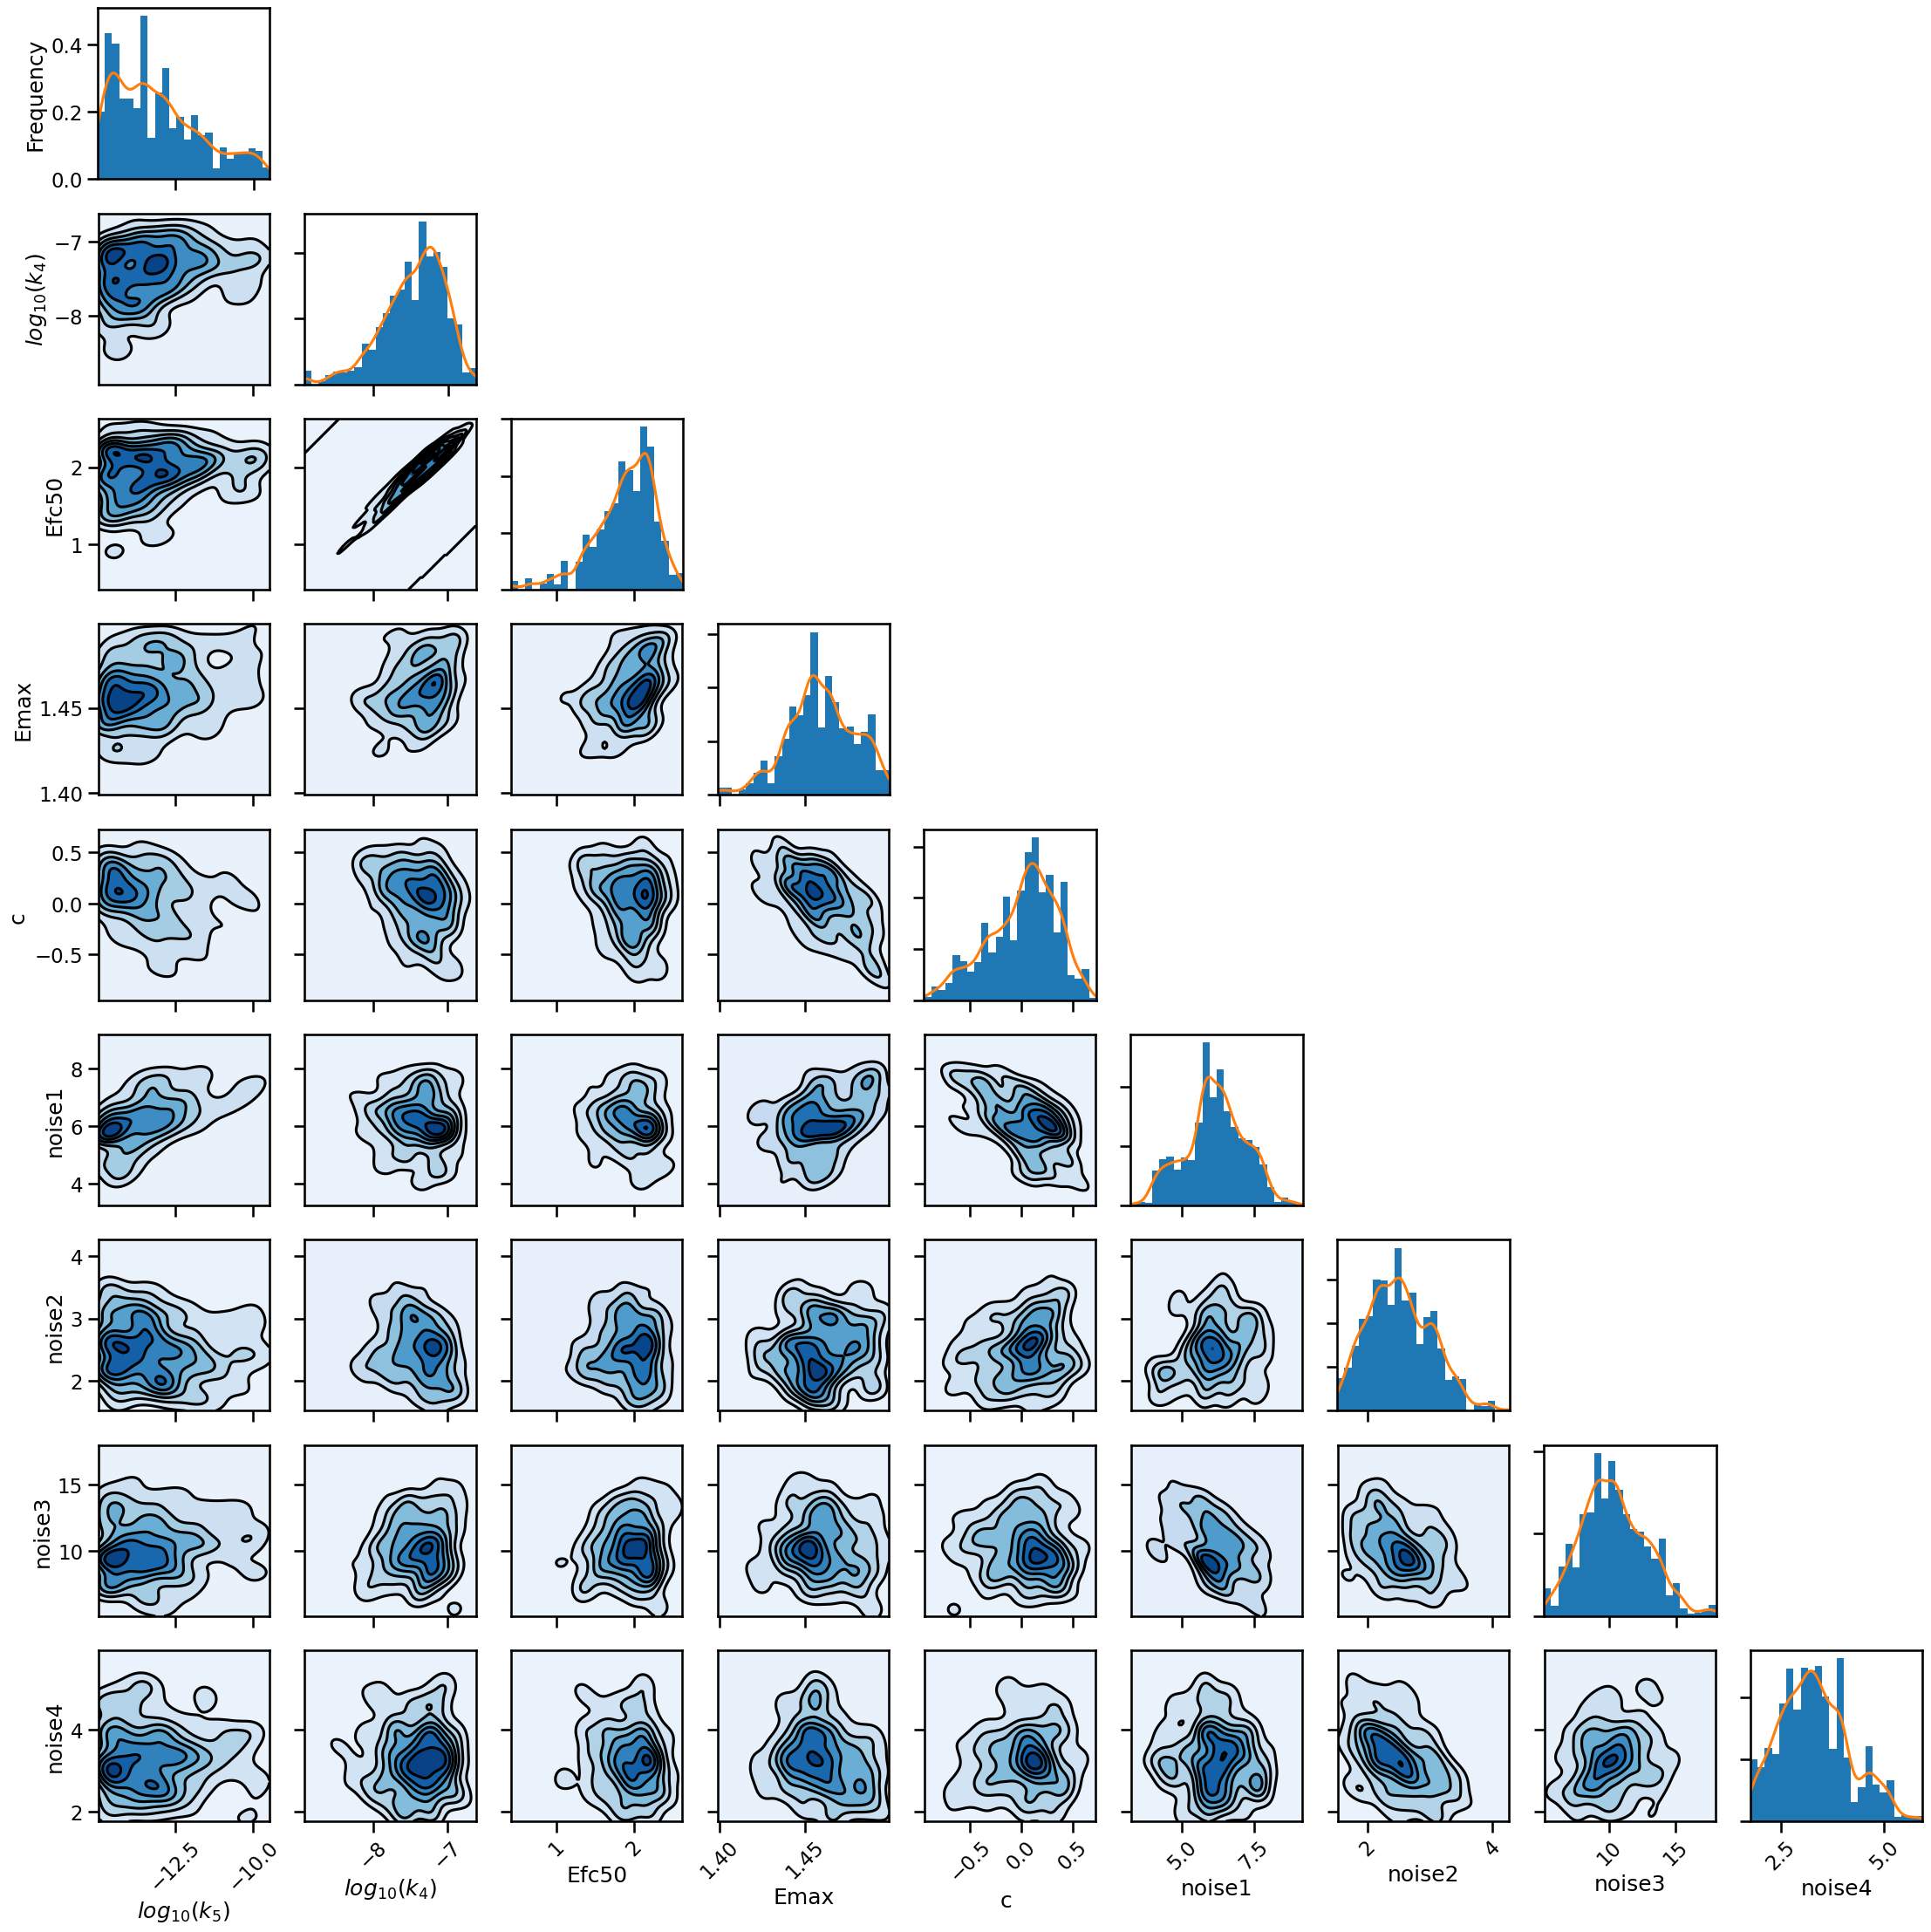

In [ ]:
pints.plot.pairwise(chain, kde=True,  parameter_names=[r'$log_{10}(k_5)$', r'$log_{10}(k_4)$', r'Efc50', 'Emax', r'c ', 'noise1', 'noise2', 'noise3', 'noise4'])
plt.show()

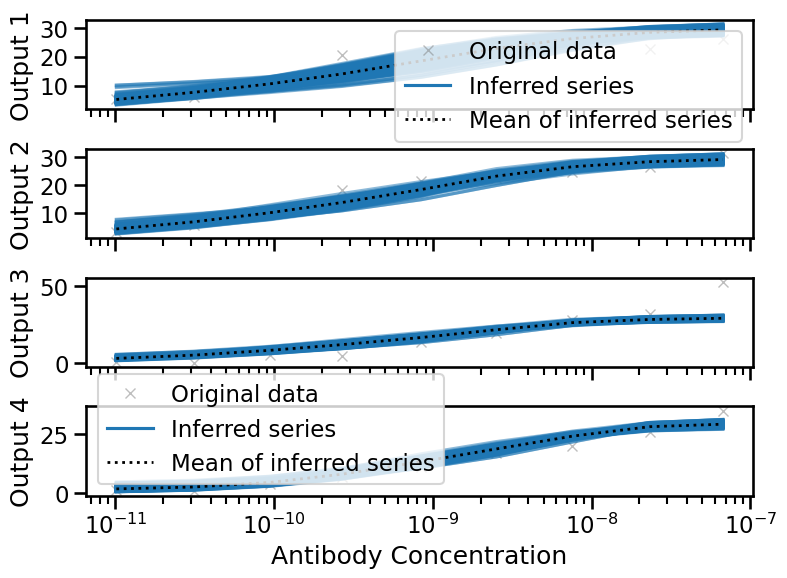

In [ ]:
fig, axes = pints.plot.series(chains1[0], problem)

#fig.set_size_inches(12,4.5)
#plt.plot(A0s1, values, c='orange', label='data')
plt.legend()
plt.xscale('log')
plt.xlabel(r'Antibody Concentration')
plt.show()

In [ ]:
# Create fine-grained list of times for plotting
n_fine = 10
times_fine = np.geomspace(min(A0s1), max(A0s1), n_fine)
# Plot some predictions with these samples
num_lines = 1
sim1 = np.zeros_like(n_fine)
sim2 = np.zeros_like(n_fine)
sim3 = np.zeros_like(n_fine)
sim4 = np.zeros_like(n_fine)
parameters = [-13.07, -8.71, 0.14, 0.53, 1.09, 0.8, 1.35, 1.45, 1.61, 1.48]
temp = simulate_model(times_fine, parameters)
sim1 = temp[:, 0]
sim2 = temp[:, 1]
sim3 = temp[:, 2]
sim4 = temp[:, 3]


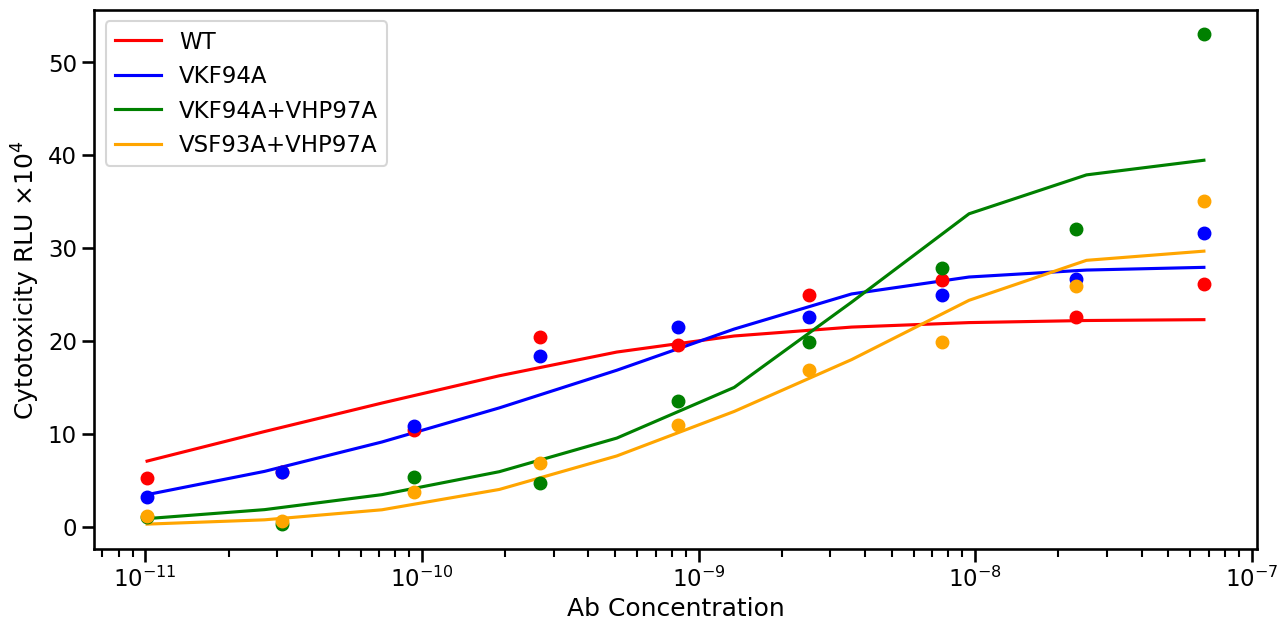

In [ ]:
import seaborn as sns
sns.set_context('talk')

plt.figure(figsize=(15, 7))
plt.xlabel('Ab Concentration')
plt.ylabel(r'Cytotoxicity RLU $\times 10^4$')
plt.plot(times_fine, sim1, color='red', label = 'WT')
plt.plot(times_fine, sim2, color='blue', label='VKF94A')
plt.plot(times_fine, sim3, color='green', label='VKF94A+VHP97A')
plt.plot(times_fine, sim4, color='orange', label ='VSF93A+VHP97A')
plt.plot(A0s1, values[:, 0], 'o', c='red')
plt.plot(A0s1, values[:, 1], 'o', c='blue')
plt.plot(A0s1, values[:, 2], 'o', c='green')
plt.plot(A0s1, values[:, 3], 'o', c='orange')
plt.xscale('log')
plt.legend(loc='best')
plt.show()